## Libraries

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Calidad de vida

In [ ]:
df = pd.read_csv("../../Data/encuesta_calidad_vida.csv",low_memory=False)

In [ ]:
dicc = pd.read_excel("../../Data/Diccionario-de-Datos-ECV2022-1.xlsx",sheet_name="Variables",skiprows=3)

In [62]:
df["P_18"]

0         43
1         21
2         65
3         49
4         51
          ..
361488    18
361489    55
361490    77
361491    32
361492    28
Name: P_18, Length: 361493, dtype: int64

In [63]:
df.columns[10:]

Index(['P_10', 'P_11', 'P_12', 'P_14', 'P_15', 'P_16', 'P_17', 'P_18', 'P_19',
       'P_20',
       ...
       'P_333', 'P_334', 'P_335', 'P_336', 'P_337', 'P_338', 'P_339', 'P_340',
       'P_341', 'P_342'],
      dtype='object', length=349)

In [64]:
columns = {"P_6":"Comuna","P_10":"Estrato","P_15":"Sexo",
           "P_18":"Edad",
           "P_35":"Lectoescritura","P_36":"EstudiaActualmente",
           "P_45":"EstudioAprobado","P_63":"AfiliacionSeguridad",
           "P_178":"Internet",
           "P_87":"Salario","P_226":"ViviendaOcupada","P_228":"ArriendoMensual",
           "P_244":"GastosMensuales","P_254":"IngresosAnuales",
           "P_258":"ViviendaNuevaPensamiento",
           "P_307":"ConocePlanificacion","P_308":"Planifica"}

In [65]:
df = df[list(columns.keys())]
df.rename(columns=columns,inplace=True)

## Mapas

In [66]:
import geopandas as gpd
geo_df = gpd.read_file("comunas_y_corregimientos.geojson")
geo_df = geo_df.drop([19,21],axis = 0)
geo_df = geo_df.astype({"codigo":"int64"})

In [67]:
geo_df.set_index("codigo",inplace=True)

### Intenet

In [69]:
internet = df[["Comuna","Internet"]].value_counts()

In [70]:
# Group by Comuna and count the total number of people
total_count = df.groupby('Comuna').size()
# Group by Comuna and count the number of people with Internet (1)
internet_count = df[df['Internet'] == 1].groupby('Comuna').size()
# Calculate the percentage
percentage_internet = (internet_count / total_count) * 100
# Display the result
percentage_internet = percentage_internet.reset_index()
percentage_internet.rename(columns={0: "PorcentajeInternet", "Comuna": "codigo"}, inplace=True)
percentage_internet.set_index("codigo", inplace=True)

In [71]:
geo_df = geo_df.join(percentage_internet)

In [ ]:
geo_df.to_file("../../un/datosCalidadDeVida.json", driver="GeoJSON")

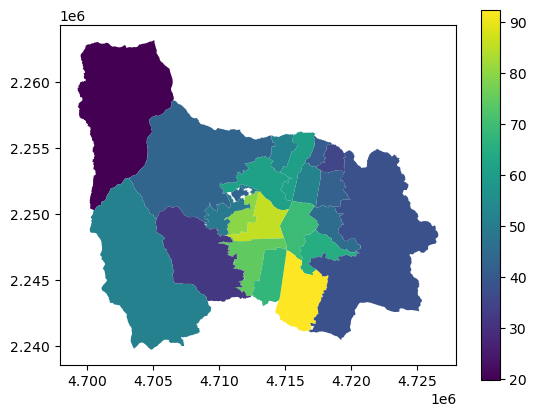

In [73]:
geo_df.plot(column="PorcentajeInternet",cmap="viridis",legend=True)
plt.show()

#### Estratos

In [74]:
estratos = df[["Comuna","Estrato"]].groupby("Comuna",as_index=False).mean().rename(columns={"Comuna":"codigo"}).set_index("codigo")

In [75]:
estratos["Estrato"] = estratos["Estrato"].astype("int64")

In [76]:
geo_df = geo_df.join(estratos)

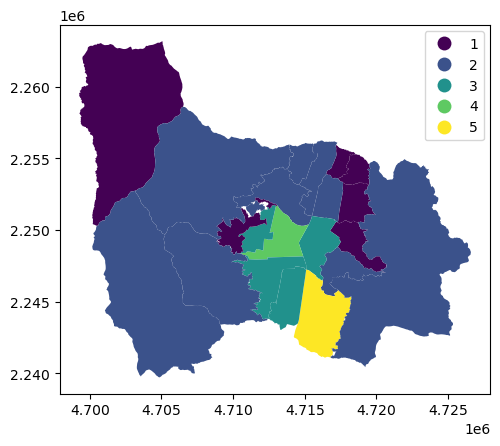

In [77]:
ax = geo_df.plot(column="Estrato",cmap="viridis",legend=True,categorical = True)

#### Salarios

In [78]:
salarios = df[df["Salario"] > 0][["Comuna","Salario"]].groupby("Comuna",as_index = False).mean().rename(columns={"Comuna":"codigo"}).set_index("codigo")

In [79]:
geo_df = geo_df.join(salarios)

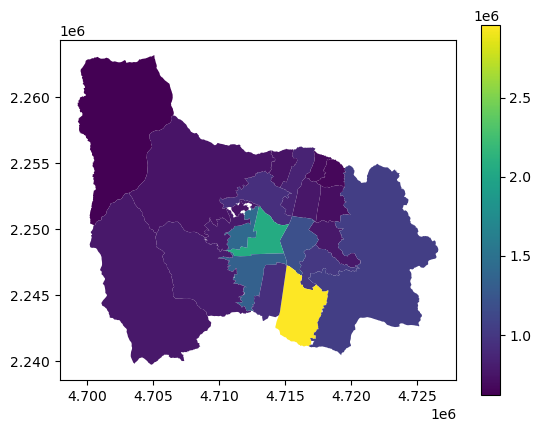

In [80]:
ax = geo_df.plot(column="Salario",
                 legend_kwds = {"fmt": "{:.0f}"},
                 k = 5,cmap="viridis",legend=True)

#### Educacion

In [81]:
estratos = df[["Comuna","Estrato"]].groupby("Comuna",as_index=False).mean().rename(columns={"Comuna":"codigo"}).set_index("codigo")

In [82]:
estudios = df[["Comuna","EstudioAprobado"]].groupby("Comuna",as_index=False).agg(pd.Series.mode).rename(columns={"Comuna":"codigo"}).set_index("codigo")

In [83]:
geo_df = geo_df.join(estudios)

In [84]:
estudios_dict = {-99: "No responde",
                 -98: "No sabe",
                 0: "No estudió",
                1: "Salacuna, guarderia, Preescolar",
                 2: "Primaria -1º a 5º-",
                 3: "Secundaria -6º a 9º-",
                 4: "Media Académica o normalista-10° a 13°-",
                 5: "Media Técnica -2 años-",
                 6: "Tecnológico -2-3 años-",
                 7: "Universidad -4 a 7 años-",
                 8: "Especializacion -2 años-",
                 9: "Maestria -3 años-",
                 10: "Doctorado -5 años-",
                 11: "Educación no formal"}

In [85]:
geo_df["EstudioAprobado"] = geo_df["EstudioAprobado"].map(estudios_dict)

<Axes: >

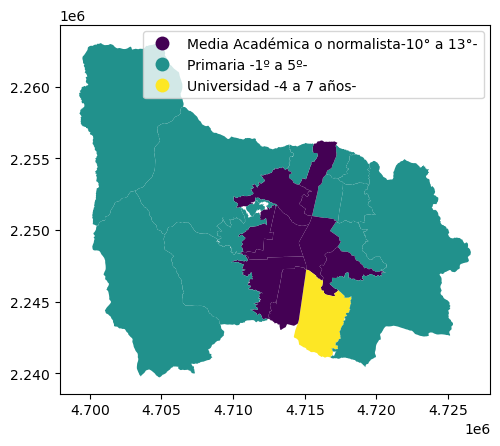

In [86]:
geo_df.plot(column="EstudioAprobado",cmap="viridis",legend=True,categorical = True)

In [87]:
# Filter the dataframe for people with Edad between 18 and 40
df_educated = df[df["EstudioAprobado"] > 4]

# Group by Comuna and count the number of people in this age range
educated_group_count = df_educated.groupby('Comuna').size()

# Group by Comuna and count the total number of people
total_count = df.groupby('Comuna').size()

# Calculate the percentage
percentage_educated_group = (educated_group_count / total_count) * 100

In [88]:
percentage_educated_group = percentage_educated_group.reset_index()
percentage_educated_group.rename(columns={0:"PorcentajeEducado", "Comuna":"codigo"},inplace=True)
percentage_educated_group.set_index("codigo",inplace=True)

In [89]:
geo_df = geo_df.join(percentage_educated_group)

<Axes: >

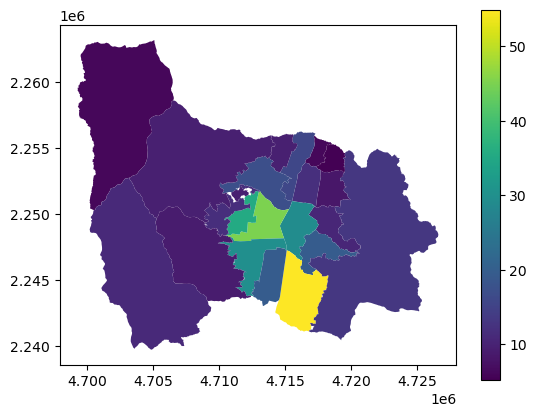

In [90]:
geo_df.plot(column="PorcentajeEducado",cmap="viridis",legend=True)

#### Renta

In [91]:
arriendo = df[["Comuna","ArriendoMensual"]].groupby("Comuna",as_index=False).mean().rename(columns={"Comuna":"codigo"}).set_index("codigo")

In [92]:
geo_df = geo_df.join(arriendo)

<Axes: >

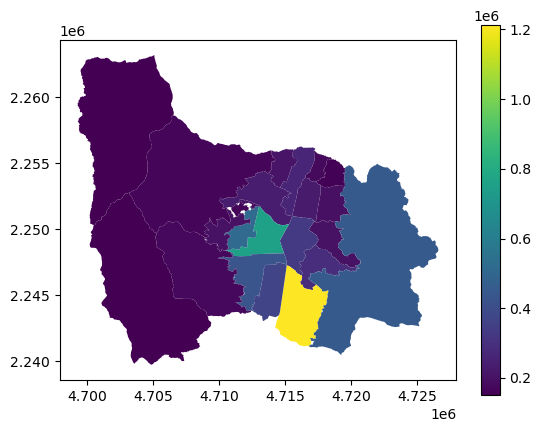

In [93]:
geo_df.plot(column = "ArriendoMensual",cmap="viridis",legend=True)

#### Incomes

In [94]:
ingresos = df[["Comuna","IngresosAnuales"]].groupby("Comuna",as_index=False).mean().rename(columns={"Comuna":"codigo"}).set_index("codigo")

In [95]:
geo_df = geo_df.join(ingresos)

<Axes: >

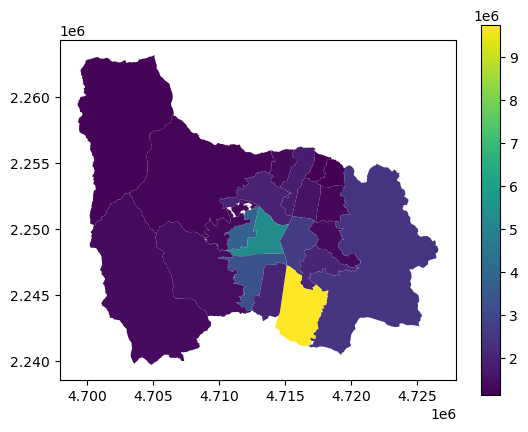

In [96]:
geo_df.plot(column = "IngresosAnuales",cmap="viridis",legend=True)

#### Crecimiento de cantidad de viviendas

In [97]:
diccionario_vivienda = {-99: "No responde",
                        -98: "No sabe",
                        1: "Aumentado",
                        2: "Igual",
                        3: "Disminuido"}

In [98]:
df["ViviendaNuevaPensamiento"] = df["ViviendaNuevaPensamiento"].map(diccionario_vivienda)

In [99]:
viviendaPensamiento = df[["Comuna","ViviendaNuevaPensamiento"]].groupby("Comuna",as_index=False).agg(pd.Series.mode).rename(columns={"Comuna":"codigo"}).set_index("codigo")

In [100]:
geo_df = geo_df.join(viviendaPensamiento)

<Axes: >

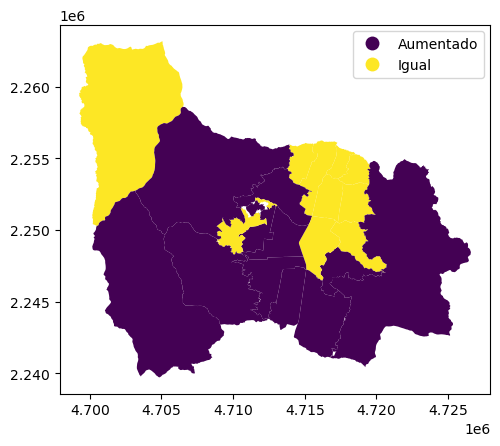

In [101]:
geo_df.plot(column = "ViviendaNuevaPensamiento",cmap="viridis",legend=True,categorical = True)

In [102]:
df

,Comuna,Estrato,Sexo,Edad,Lectoescritura,EstudiaActualmente,EstudioAprobado,AfiliacionSeguridad,Internet,Salario,ViviendaOcupada,ArriendoMensual,GastosMensuales,IngresosAnuales,ViviendaNuevaPensamiento,ConocePlanificacion,Planifica
0,1,2,2,43,1,2,3,0,2,-88,3,250000,335000,360000.0,Igual,1,1
1,1,2,1,21,1,2,4,-88,2,240000,3,250000,335000,360000.0,Igual,1,1
2,1,2,1,65,1,2,2,-88,2,-88,3,250000,335000,360000.0,Igual,1,1
3,11,5,2,49,1,2,7,-88,1,-99,3,5000000,0,0.0,Disminuido,2,1
4,11,5,2,51,1,2,6,2,1,-88,3,5000000,0,0.0,Disminuido,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361488,13,2,1,18,1,2,4,-88,1,-88,3,250000,512400,180000.0,Aumentado,2,2
361489,13,2,2,55,1,2,2,0,1,700000,3,250000,512400,180000.0,Aumentado,2,2
361490,80,3,1,77,2,2,0,-88,2,-88,3,150000,160000,450000.0,Aumentado,1,2
361491,80,3,1,32,1,2,5,-88,2,1000000,1,-88,770000,950000.0,Igual,1,2


#### Edad

In [103]:
# Filter the dataframe for people with Edad between 18 and 40
df_filtered = df[(df['Edad'] >= 18) & (df['Edad'] <= 40)]

# Group by Comuna and count the number of people in this age range
age_group_count = df_filtered.groupby('Comuna').size()

# Group by Comuna and count the total number of people
total_count = df.groupby('Comuna').size()

# Calculate the percentage
percentage_age_group = (age_group_count / total_count) * 100

# Display the result


In [104]:
percentage_age_group = percentage_age_group.reset_index()
percentage_age_group.rename(columns={0:"PorcentajeJoven", "Comuna":"codigo"},inplace=True)
percentage_age_group.set_index("codigo",inplace=True)

In [105]:
geo_df = geo_df.join(percentage_age_group)

<Axes: >

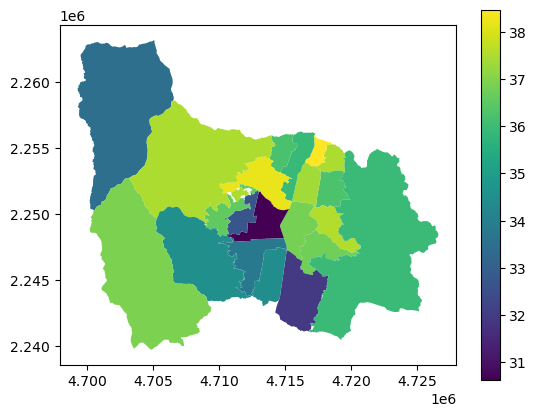

In [106]:
geo_df.plot(column = "PorcentajeJoven",cmap="viridis",legend=True)

#### Porcentaje Gente joven y Educada

In [107]:
# Filter the dataframe for people with Edad between 18 and 40
df_YE = df[(df['Edad'] >= 18) & (df['Edad'] <= 40) & (df['EstudioAprobado'] > 4)]

# Group by Comuna and count the number of people in this age range
YE_group_count = df_YE.groupby('Comuna').size()

# Group by Comuna and count the total number of people
total_count = df.groupby('Comuna').size()

# Calculate the percentage
percentage_YE_group = (YE_group_count / total_count) * 100

# Display the result

In [108]:
percentage_YE_group = percentage_YE_group.reset_index()
percentage_YE_group.rename(columns={0:"PorcentajeYE", "Comuna":"codigo"},inplace=True)
percentage_YE_group.set_index("codigo",inplace=True)

In [109]:
geo_df = geo_df.join(percentage_YE_group)

<Axes: >

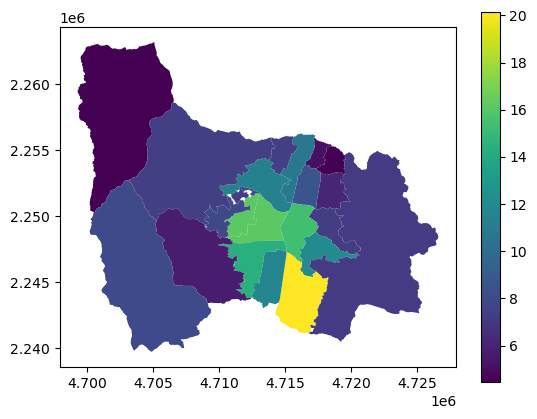

In [110]:
geo_df.plot(column = "PorcentajeYE",cmap="viridis",legend=True)

In [114]:
geo_df.head()

,OBJECTID,nombre,identificacion,limitemunicipioid,subtipo_comunacorregimiento,fecha_actualizacion,Shape_Length,Shape_Area,geometry,PorcentajeInternet,Estrato,Salario,EstudioAprobado,PorcentajeEducado,ArriendoMensual,IngresosAnuales,ViviendaNuevaPensamiento,PorcentajeJoven,PorcentajeYE
codigo,,,,,,,,,,,,,,,,,,,
1,1,Popular,Comuna 1,001,1,1418774400000,9604.447484,3.097941e+06,"POLYGON ((4718193.072 2255308.014, 4718182.769...",34.974132,1,667771.959350,Primaria -1º a 5º-,5.258928,160076.658496,1.179737e+06,Igual,37.485559,4.465317
2,2,Santa Cruz,Comuna 2,001,1,1418774400000,8597.293651,2.195663e+06,"POLYGON ((4717199.365 2255945.395, 4717195.762...",40.991268,1,677784.818111,Primaria -1º a 5º-,6.204649,179713.469438,1.149250e+06,Igual,38.457754,5.128520
3,3,Manrique,Comuna 3,001,1,1418774400000,12077.558708,5.096182e+06,"POLYGON ((4718792.583 2253310.702, 4718790.160...",42.070019,1,708305.141419,Primaria -1º a 5º-,8.176692,194814.115210,1.288859e+06,Igual,36.242951,6.171679
4,4,Aranjuez,Comuna 4,001,1,1418774400000,9642.676522,4.883314e+06,"POLYGON ((4716607.297 2253867.449, 4716607.168...",52.279183,2,765336.459107,Primaria -1º a 5º-,12.020380,226918.952748,1.575719e+06,Igual,37.364173,8.575680
5,5,Castilla,Comuna 5,001,1,1418774400000,16098.031666,6.063916e+06,"POLYGON ((4716246.187 2256230.621, 4716238.195...",60.622631,2,848079.107792,Media Académica o normalista-10° a 13°-,15.896048,259777.576773,1.839444e+06,Igual,35.890633,10.736329


In [115]:
from scipy.stats import zscore

In [118]:
Zsalary = zscore(geo_df["Salario"])
Zeducation = zscore(geo_df["PorcentajeEducado"])
Zarriendo = zscore(geo_df["ArriendoMensual"])
Zedad = zscore(geo_df["PorcentajeJoven"])

In [119]:
Z = zscore(Zsalary*0.25 + Zeducation*0.3 + Zarriendo*0.2 + Zedad*0.25)

In [123]:
geo_df["Z"] = Z

<Axes: >

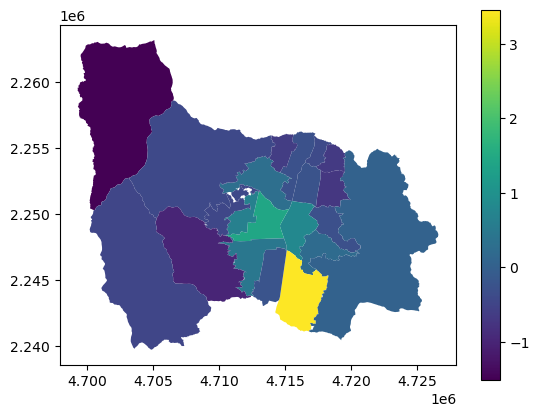

In [122]:
geo_df.plot(column = "Z",cmap="viridis",legend=True)